# BAIT 508 Group Project: Industry Analysis
> Provided by MBAN 24' UBC Sauder School of Business
----
**Group Members**
* Yinhan Chen: 
* Ruotong Xu
* Zuojie Liu




## Part 1. Quantitative Analysis of the Industry Sector

### A. Data Filtering

* We chose the *"Apparel And Other Finished Products Made From Fabrics And Similar Materials"* sector as our target. Its major_group code is 23. Therefore we only retained firms whose SIC codes start with 23. We did a int dividend to get the first two numbers.
* We used the nunique method to count the number of unique elements in each sectors.
* We used a list iterator to count the companies with 27 rows.

In [2]:
# 1. Load data
import pandas as pd

original_df = pd.read_csv('data/public_firms.csv', encoding = 'utf-8')

# 2. Filter out companies in the selected business group
df = original_df[original_df['sic']//100 ==23]

# 3. Descriptive questions
print("a. There are {} unique years in df".format(df.fyear.nunique()))
print("b. There are {} unique companies in df".format(df.conm.nunique()))
print("c. There are {} companies in df that have 27 years' records".format(
    len([i for i in df.groupby("conm").fyear.nunique() if i == 27])))

a. There are 27 unique years in df
b. There are 133 unique companies in df
c. There are 4 companies in df that have 27 years' records


### B. Preliminary Analysis

In [3]:
# 1. Top 10 firms with the highest stock price in the year 2020
df.loc[df['fyear'] == 2020].sort_values('prcc_c',ascending=False)[:10][['conm','prcc_c','fyear']]

,conm,prcc_c,fyear
194398,LULULEMON ATHLETICA INC,348.030,2020
40107,UNIFIRST CORP,211.690,2020
56233,LVMH MOET HENNESSY LOUIS V,125.023,2020
138806,RALPH LAUREN CORP,103.740,2020
47867,WACOAL HOLDINGS CORP,100.538,2020
177364,CARTER'S INC,94.070,2020
31373,PVH CORP,93.890,2020
149123,COLUMBIA SPORTSWEAR CO,87.380,2020
41136,VF CORP,85.410,2020
29751,OXFORD INDUSTRIES INC,65.510,2020


In [4]:
# 2. Top 10 firms with the highest sales in the entire history
df.sort_values("sale",ascending=False).drop_duplicates(subset='conm')[:10][['conm','sale','fyear']]

,conm,sale,fyear
56232,LVMH MOET HENNESSY LOUIS V,60227.544,2019
41134,VF CORP,13848.660,2018
31372,PVH CORP,9909.000,2019
138800,RALPH LAUREN CORP,7620.000,2014
61835,LEVI STRAUSS & CO,7164.632,1996
190849,HANESBRANDS INC,6966.923,2019
204536,CAPRI HOLDINGS LTD,5551.000,2019
186910,UNDER ARMOUR INC,5267.132,2019
81311,JONES GROUP INC,5074.200,2005
23199,KATE SPADE & CO,4994.318,2006


In [5]:
# 3. Top 10 locations 
df[['location','conm']].drop_duplicates().location.value_counts()[:10]

location
USA    115
CHN      4
ISR      3
CAN      3
GBR      2
JPN      1
FRA      1
ITA      1
NLD      1
AUS      1
Name: count, dtype: int64

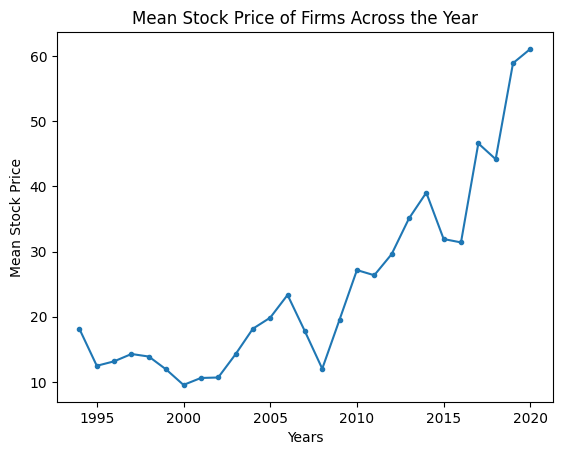

In [6]:
# 4. Line chart: the average stock price across the years. 
import matplotlib.pyplot as plt
mean_yearly_stock_price = df.groupby('fyear')['prcc_c'].mean()
mean_yearly_stock_price.plot(kind='line', marker='.')
plt.title('Mean Stock Price of Firms Across the Year')
plt.xlabel('Years')
plt.ylabel('Mean Stock Price')
plt.show()

In [7]:
# 5. Firm affected most in 2008 

pivot_df = df.pivot_table(index='conm', columns='fyear', values='prcc_c')
pivot_df['percentage_drop'] = ((pivot_df[2008] - pivot_df[2007]) / pivot_df[2007]) * 100
result = pivot_df.sort_values(by = 'percentage_drop').index[0]
print(result)

INCA DESIGNS INC


#### Citation:
- Source: GPT-4
- Prompt: "Suppose that there is a dataset, each observation is a company. The same company can have several records over different years, and 'year' is one of the column. "stock_price" is another column. How to check each firm's percentage drop in stock price from 2007 to 2008?"
- Result:

> To calculate each firm's percentage drop in stock price from 2007 to 2008, follow these steps:
> 1. Filter the data for the years 2007 and 2008.
> 2. Use the pivot or pivot_table function to reshape the data so that firms are in the rows, years are in the columns, and stock prices are the values.
> 3. Calculate the percentage drop for each firm.
> 
> Here's a step-by-step example using a hypothetical dataset:
> ```python
> import pandas as pd
> data = {
>    'firm': ['A', 'A', 'B', 'B', 'C', 'C'],
>    'year': [2007, 2008, 2007, 2008, 2007, 2008],
>    'stock_price': [100, 90, 150, 100, 200, 150]
> }
> df = pd.DataFrame(data)
> pivot_df = df.pivot_table(index='firm', columns='year', values='stock_price')
> pivot_df['percentage_drop'] = ((pivot_df[2008] - pivot_df[2007]) / pivot_df[2007]) * 100
> result = pivot_df['percentage_drop']
> print(result)
> ```




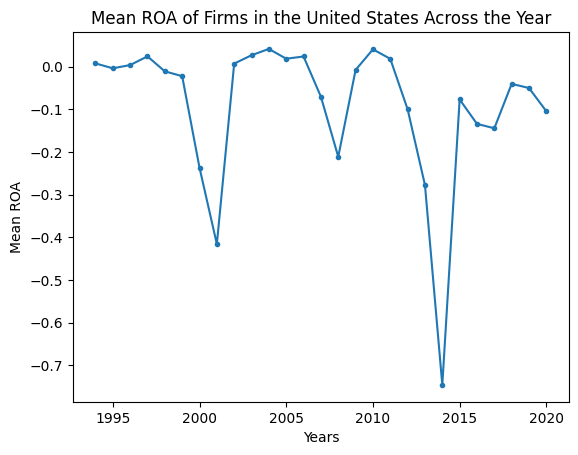

In [8]:
# 6. Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years.
# ROA is calculated as ni/asset

# Make a copy of df in order not to change the original dataframe
USA_firms = df.copy()

# Filter and extract firms located in the USA
USA_firms = USA_firms[USA_firms['location'] == 'USA']

# Add a column 'roa' to the new df, and calculate the ROA value by ni/asset of each row
USA_firms['roa'] = USA_firms['ni'] / USA_firms['asset']

# First group the USA_firms by years, then calculate the mean ROA for each year
mean_yearly_roa = USA_firms.groupby('fyear')['roa'].mean()

# Plot the line chart directly on the grouped pandas series
mean_yearly_roa.plot(kind = 'line', marker = '.')
plt.title('Mean ROA of Firms in the United States Across the Year')
plt.xlabel('Years')
plt.ylabel('Mean ROA')
plt.show()

## Part 2. Text Analysis on the Industry Sector


### C. Text Cleaning

* We defined a function clean_text that can change a single sentence into a formatted list of words. 
* First we use str.lower() method to lower the upper case. 
* Then we use the str.maketrans() method to drop all punctuation characters. 
* Then we removed all the stopwords downloaded from NLTK by a list iterator.
* Finally we apply the apply() method to change all elements of df_10K.

In [9]:
# 0. load data and download nltk stopwords
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
df_10K = pd.read_csv("data/2020_10K_item1_full.csv", encoding = 'utf-8')
df_10K.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aizenz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614
4,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614


In [10]:
# 1. Convert all words to lowercase.
# 2. Remove punctuations
# 3. Remove stop words based on the list of English stop words in NLTK

def clean_text(text):
    # Lower case
    text = text.lower()

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stopwords
    sw = stopwords.words('english')
    clean_words = [w for w in text.split() if w not in sw]
    
    return ' '.join(clean_words)

df_10K['item_1_clean'] = df_10K['item_1_text'].apply(clean_text)

### D. Keyword Analysis

In [11]:
# 1. Align firms with 10-K data
merged_df = pd.merge(df.loc[df['fyear']==2020], df_10K, on='gvkey', how='inner')


In [12]:
# 2.1 Top 10 keywords by word counts 
from collections import Counter

def get_keywords_wc(text):
    c = Counter(text.split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join(words)

merged_df['keyword_clean_wc'] = merged_df['item_1_clean'].apply(get_keywords_wc)
merged_df['keyword_clean_wc']

0     partnership properties limited leases net gene...
1     brands hilfiger klein tommy calvin products br...
2     products segment superior promotional company ...
3     service president company vice customers servi...
4     vf stores products brand president brands 2020...
5     fiscal products year 2019 net stores levi reve...
6     business vince fiscal stores wholesale rebecca...
7     registrant gas oil md program partner interest...
8     jordan garments jerash 2020 approximately prod...
9     products brands product stores us branded glob...
10    stores guess products retail wholesale us 2020...
11    lauren ralph stores products business digital ...
12    products president vice company wholesale cust...
13    products manufacturing facilities apparel fisc...
14    products brand retail carter stores us market ...
15    products apparel footwear brand performance pr...
16    go everglory la business customers apparel ret...
17    company investment nfid brand 2018 busines

In [13]:
# 2.2 Top 10 keywords by TF-IDF score
from sklearn.feature_extraction.text import TfidfVectorizer
def get_keywords_tfidf(document_list):
    '''
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''

    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)

    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):

        if i %100 == 0:
            print(f'Processing the {i}/{len(document_list)} document.')
        
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    
    return top_keywords

merged_df['keyword_clean_tfidf'] =  get_keywords_tfidf(merged_df['item_1_clean'].tolist())
merged_df['keyword_clean_tfidf']

Processing the 0/21 document.


0     partnership properties leases proceeds tenants...
1     tommy hilfiger klein calvin brands brand izod ...
2     products promotional superior bamko segment un...
3     president vice service croatti served rental m...
4     vf president stores products brand vfoperated ...
5     levi fiscal revenues year products stores net ...
6     vince taylor rebecca parker fiscal wholesale s...
7     registrant oil gas md drilling interests crude...
8     jordan jerash garments victory workshop jordan...
9     wrangler lee products kontoor vf brands stores...
10    guess stores concessions retail wholesale prod...
11    lauren ralph stores polo commerce products dig...
12    products columbia president vice boyle prana m...
13    delta salt soffe manufacturing products facili...
14    carter oshkosh brand hop skip young products c...
15    products fitness athletes apparel armour footw...
16    everglory go la goldenway prc tax xin tai nanj...
17    nfid company ric 1940 status investment re

In [14]:
# 3. Create two wordclouds to visualize the keywords across all firms in the selected sector: 
# one based on the word count of keywords and another based on the TF-IDF score
from wordcloud import WordCloud

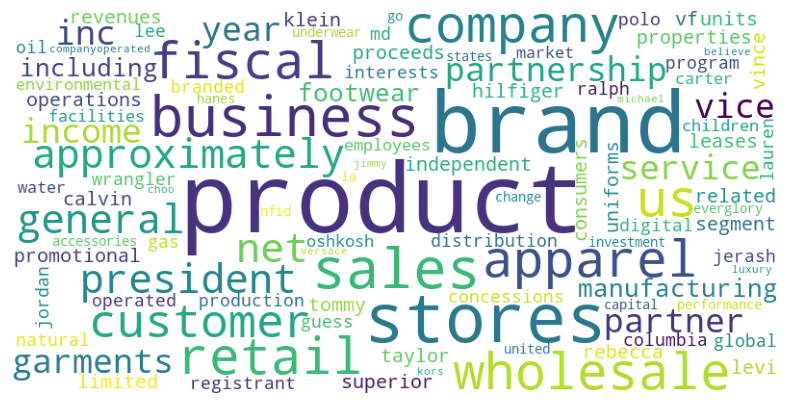

In [15]:
# 3.1 Wordcloud based on word count results
# prepare text
text_wc = ' '.join(merged_df['keyword_clean_wc'].tolist())
wordcloud1 = WordCloud(width=800, height=400, max_font_size= 100, background_color='white').generate(text_wc) # note that text is a string, not a list

plt.figure(figsize=(10,5))
plt.imshow(wordcloud1)
#plt.savefig('keyword_wc.png') # save as PNG file
plt.axis('off')
plt.show()

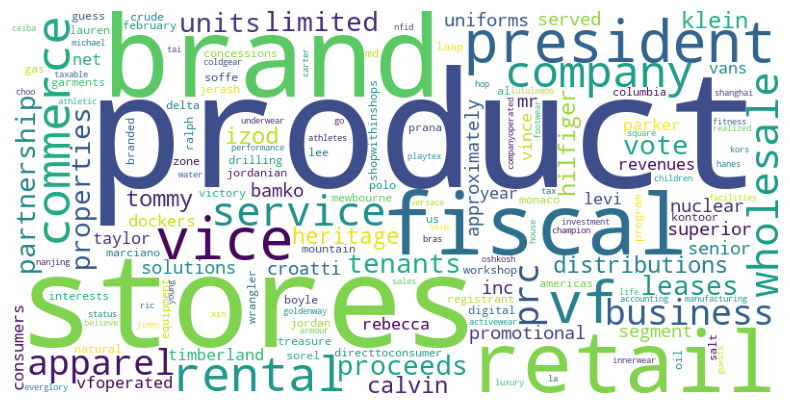

In [16]:
# 3.2 Wordcloud based on TF-IDF results

# prepare text
text_tfidf = ' '.join(merged_df['keyword_clean_tfidf'].tolist())
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_tfidf) # note that text is a string, not a list

plt.figure(figsize=(10,5))
plt.imshow(wordcloud2)
#plt.savefig('keyword_tfidf.png') # save as PNG file
plt.axis('off')

plt.show()

### E. Word Embedding

* Merged all words into a single list
* trained a word2vec model and save it
* Based on the wordcloud, we chose 'brand', 'product' and 'stores' as our target words.
* Found the most similar words of the three by using the mostsimilar() method.

In [17]:
# 1. Train a word2vec model with the full 10-K sample
from gensim.models import Word2Vec

# read the cleaned data in merged_df['item_1_clean'] and merge them into a list by words
sent = [row.split() for row in merged_df['item_1_clean']]

# start training
model = Word2Vec(sent, min_count=1, vector_size=50, \
                 workers=3, window=3, sg = 1)
# Saving  models
model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model")

In [18]:
# 2. Manually inspect the wordclouds you generated in D.3 and choose three representative
# keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec
# model to find the most relevant five words for each of these three keywords.

model.wv.most_similar('brand')[:5]

[('leading', 0.9611783027648926),
 ('image', 0.9572461247444153),
 ('broad', 0.9560299515724182),
 ('outdoor', 0.9537250995635986),
 ('lifestyle', 0.9518596529960632)]

In [19]:
model.wv.most_similar('product')[:5]

[('design', 0.9587851166725159),
 ('quality', 0.9485211968421936),
 ('offerings', 0.9421351552009583),
 ('categories', 0.9381900429725647),
 ('development', 0.9341195225715637)]

In [20]:
model.wv.most_similar('stores')[:5]

[('companyoperated', 0.9588344693183899),
 ('store', 0.9540466666221619),
 ('ecommerce', 0.9516808390617371),
 ('retail', 0.951200008392334),
 ('operated', 0.9474902749061584)]

## Part 3. Comprehensive Analysis of One Sample Firm

In [21]:
# 1. Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. 
# Add up the embeddings for each firm to create the firm-level embeddings. 
# Use the firm-level embeddings to find the focal firm’s competing firms (or, most similar firms)
from DocumentSimilarity import DocumentSimilarity

d = DocumentSimilarity(model = model, gvkeys=merged_df['gvkey'], \
                       conm = merged_df['conm'], 
                       keywordslist = merged_df['keyword_clean_tfidf'])

In [22]:
# Extract the top 5 competitors of LULULEMON

d.most_similar(firm = 178015, topn = 5)

[(19175, 'VINCE HOLDING CORP', 0.9854513),
 (8219, 'OXFORD INDUSTRIES INC', 0.9814039),
 (35035, 'KONTOOR BRANDS INC', 0.98116016),
 (10198, 'SUPERIOR GROUP OF COS INC', 0.97879577),
 (63447, 'GUESS INC', 0.97067153)]

In [23]:
# Records of LULULEMON ATHLETICA INC across all years

luludf = original_df[original_df['gvkey'] == 178015]
luludf

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
194383,178015,2005,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,NaN,3.877,1.394,41.914,84.129,0.033259
194384,178015,2006,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,NaN,16.029,7.666,71.855,148.885,0.106687
194385,178015,2007,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,47.37,53.339,30.842,155.092,274.713,0.198863
194386,178015,2008,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,7.93,56.797,39.363,211.636,353.488,0.185994
194387,178015,2009,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,30.10,159.573,58.281,307.258,454.198,0.189681
194388,178015,2010,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,68.42,316.286,121.847,499.302,711.704,0.244035
194389,178015,2011,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,46.66,409.437,184.063,734.634,1000.839,0.250551
194390,178015,2012,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,76.23,590.179,270.556,1051.078,1370.358,0.257408
194391,178015,2013,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,59.03,698.649,279.547,1249.688,1591.188,0.223693
194392,178015,2014,CAN,LULULEMON ATHLETICA INC,2007/07/27,2300,55.79,664.479,239.033,1296.213,1797.213,0.184409


In [24]:
# Record of KONTOOR BRANDS INC in 2020

original_df[(original_df['conm'] == 'KONTOOR BRANDS INC') & (original_df['fyear'] == 2020)]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
115618,35035,2020,USA,KONTOOR BRANDS INC,NaN,2300,40.56,248.138,67.923,1545.816,2097.839,0.04394


In [25]:
# Record of VINCE HOLDING CORP in 2020

original_df[(original_df['conm'] == 'VINCE HOLDING CORP') & (original_df['fyear'] == 2020)]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
70098,19175,2020,USA,VINCE HOLDING CORP,2013/11/22,2300,6.36,NaN,-65.649,332.944,219.87,-0.197177


In [26]:
# Record of OXFORD INDUSTRIES INC in 2020

original_df[(original_df['conm'] == 'OXFORD INDUSTRIES INC') & (original_df['fyear'] == 2020)]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
29751,8219,2020,USA,OXFORD INDUSTRIES INC,NaN,2300,65.51,66.013,-95.692,865.634,762.857,-0.110546


In [27]:
# Recoed of SUPERIOR GROUP OF COS INC in 2020

original_df[(original_df['conm'] == 'SUPERIOR GROUP OF COS INC') & (original_df['fyear'] == 2020)]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
37320,10198,2020,USA,SUPERIOR GROUP OF COS INC,NaN,2300,23.24,5.172,41.026,393.924,526.697,0.104147


In [28]:
# Record of DELTA APPAREL INC in 2020

original_df[(original_df['conm'] == 'DELTA APPAREL INC') & (original_df['fyear'] == 2020)]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
167628,137432,2020,USA,DELTA APPAREL INC,2000/06/30,2300,20.07,16.458,-10.577,420.231,381.535,-0.025169


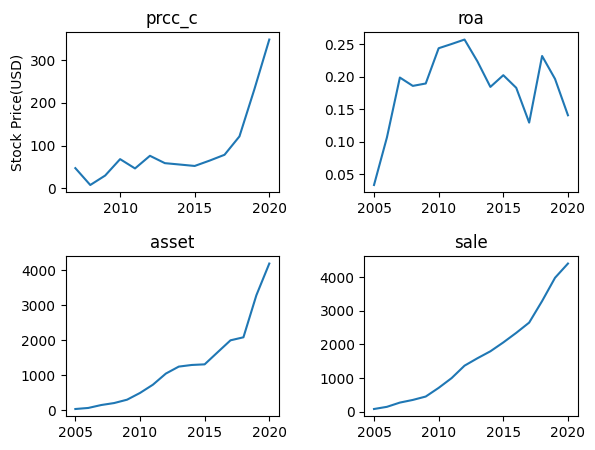

In [29]:
# visualize LULULEMON's financial situation
fig, ax = plt.subplots(2,2)

# prcc_c
ax[0,0].plot(list(luludf['fyear']),
             list(luludf['prcc_c']))
ax[0,0].set_title("prcc_c")
ax[0,0].set_ylabel("Stock Price(USD)")

# asset
ax[1,0].plot(list(luludf['fyear']),
             list(luludf['asset']))
ax[1,0].set_title("asset")

# sale
ax[1,1].plot(list(luludf['fyear']),
             list(luludf['sale']))
ax[1,1].set_title("sale")

# roa
ax[0,1].plot(list(luludf['fyear']),
             list(luludf['roa']))
ax[0,1].set_title("roa")

# change the discrepancy
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)


